In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import accumulate
import re
from sisl import *
from sisl.io import *
import sisl.viz
# from sisl.viz import merge_plots
from time import time
from scipy import linalg
import os
import h5py
import random
%matplotlib inline

### 读取预测的能带结构

In [2]:
input_path = '/fs2/home/ndsim10/DeepH-final/si_example/work_dir/olp/si_432_mix_defect/'
# 初始化变量
E_F = None
k_min = None
k_max = None
total_bands = None
bands_data = []
current_band = []

ev2Hartree = 0.036749324533634074
Bohr2Ang = 0.529177249

# 打开deeph预测的siesta.dat文件并逐行读取
with open(input_path + 'bands.dat', 'r') as file:
    for line in file:
        # 去除行尾的换行符
        line = line.strip()
        # 检查是否是参数行
        if line.startswith('# E_F'):
            E_F = float(line.split('=')[1])
        elif line.startswith('# k_min, k_max'):
            k_values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            k_min, k_max = map(float, k_values)
        # elif line.startswith('# E_min, E_max'):
        #     matches = re.findall(r"[-+]?\d*\.\d+([eE][-+]?\d+)?|\d+([eE][-+]?\d+)?", line)
        #     E_values = [match[0] + (match[1] if match[1] else '') for match in matches]
        #     print(E_values)
        #     E_min, E_max = map(float, E_values)
        # elif line.startswith('# Nbands, Nspin, Nk'):
        #     P_total_bands = int(line.split('=')[1].split('\t')[1])
        # 检查是否是数据行
        elif re.match(r"^\d", line):
            current_band.append(list(map(float, line.split())))
        # 如果遇到空行且当前组数据不为空，则开始新的数据组
        elif line == '' and current_band:
            bands_data.append(np.array(current_band))
            current_band = []

# 如果最后一组数据非空，也添加到bands_data中
if current_band:
    bands_data.append(np.array(current_band))

# 打印提取的参数
print(f"E_F = {E_F}")
print(f"k_min = {k_min}")
print(f"k_max = {k_max}")
# print(f"Predicted Total number of bands = {P_total_bands}")
# 打印第一组数据用于验证
# print("First group of predicted data:")
# for data in P_bands_data[0]:
#     print(data)

# assert len(bands_data) == len(P_bands_data)

elements = []
with open(input_path + 'input.fdf', 'r') as file:
    within_block = None
    for line in file:
        # 检查是否到达区块开始
        if '%block Band' in line:
            within_block = True
            continue  # 跳过当前行，不做处理
        # 检查是否到达区块结束
        elif '%endblock Band' in line:
            within_block = False
            break  # 区块结束，退出循环
        # 处理区块内的内容
        if within_block:
            element = line.split()  # 拆分行内容为列表
            if element:  # 确保行非空
                elements.append(element)
xticks_list = [str(element[-1]) for element in elements]
xticks_v_list = [int(element[0]) for element in elements]
cumulative_sums = list(accumulate(xticks_v_list))
new_xticks = [item - 1 for item in cumulative_sums]
print(xticks_list)
print(new_xticks)
plt.figure(figsize=(10,8))
for i in range(len(bands_data)):
    k_points = bands_data[i][:,0] / Bohr2Ang  # k点数据
    bands = bands_data[i][:,1]  - E_F#费米能级归零  石墨烯：3.6522, 

    # print(predict_k_points)
    # 仅为第一条曲线和散点添加图例
    if i == 0:
        plt.plot(k_points, bands , color='blue', linewidth=2.0, label='Siesta')  # 绘制每条能带
        plt.scatter(k_points, bands  + random.uniform(-0.001, 0.001), marker='o', color='red', s=30, label='HaMLR')  # 绘制每条能带
    else:
        plt.plot(k_points, bands , color='blue', linewidth=2.0)  # 绘制每条能带
        plt.scatter(k_points, bands + random.uniform(-0.001, 0.001), marker='o', color='red', s=30)  # 绘制每条能带


plt.xlabel('Wave Vector k', fontsize=30)
plt.ylabel('Energy (eV)', fontsize=30)
plt.ylim(-1.5, 1.5) #eV
plt.xlim(k_points[0], k_points[-1])
plt.xticks([k_points[new_xtick] for new_xtick in new_xticks], xticks_list, fontsize=30)
plt.yticks(fontsize=30)
plt.title('Band Structure', fontsize=30)
plt.grid(True)
plt.legend(loc='center', bbox_to_anchor=(0.5, 0.5), fontsize=30)
# # 将图例标签移到图的右侧外面
# plt.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1.05, 1.0), borderaxespad=0.)
# # 调整布局以避免重叠
# plt.tight_layout()

# 保存为矢量图
plt.savefig("/fs2/home/ndsim10/DeepH-final/si_example/work_dir/olp/si_432_mix_defect/si_432_mix_defect_band_structure.tiff", format='tiff', dpi=300, bbox_inches='tight')
plt.show()

E_F = -4.4377
k_min = 0.0
k_max = 1.4181


FileNotFoundError: [Errno 2] No such file or directory: '/fs2/home/ndsim10/all-kinds-test/si/si_pn_384/electrode-left/input.fdf'

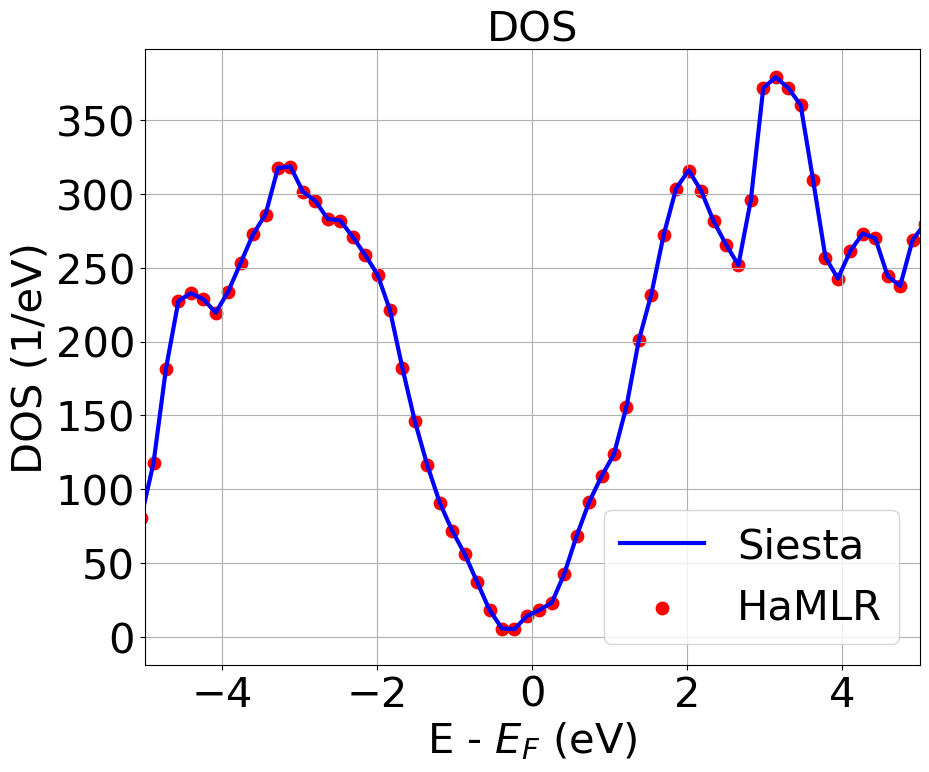

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import random

# input_path = '/fs2/home/ndsim10/all-kinds-test/graphene-defect/DV5555-6-7777/'
dos_data1 = np.loadtxt(input_path + 'dos.dat')
# dos_data2 = np.loadtxt('/fs2/home/ndsim10/deeph/example/work_dir/olp/5_4/dos.dat')
E_points = dos_data1[:,0]
#费米能级：SVED:-3.835； SV59:-3.8947;  SV55-66:-3.835;  SW:-3.6111
DOS1 = dos_data1[:,3] #1up,2down,3total   #450个原子fermi_level = -3.6522  + 3.7697
# DOS2 = DOS1 + np.random.uniform(-1, 1)
plt.figure(figsize=(10,8))
plt.plot(E_points - E_F, DOS1, color='blue', linewidth=3.0, label="Siesta")  # 绘制每条能带
plt.scatter(E_points - E_F, DOS1+random.uniform(-0.1, 0.1), marker='o',color='red', s=80, label="HaMLR")
plt.xlim(-5, 5)
# plt.ylim(0, 300)
plt.xlabel(r'E - $E_F$ (eV)', fontsize=30)#r'MAE of $H^\prime_{iu, jv}$'
plt.ylabel('DOS (1/eV)', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title('DOS', fontsize=30)
plt.grid(True)
plt.legend(fontsize=30)
plt.savefig('/fs2/home/ndsim10/DeepH-final/si_example/work_dir/olp/si_432_mix_defect/si_432_mix_defect_DOS.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

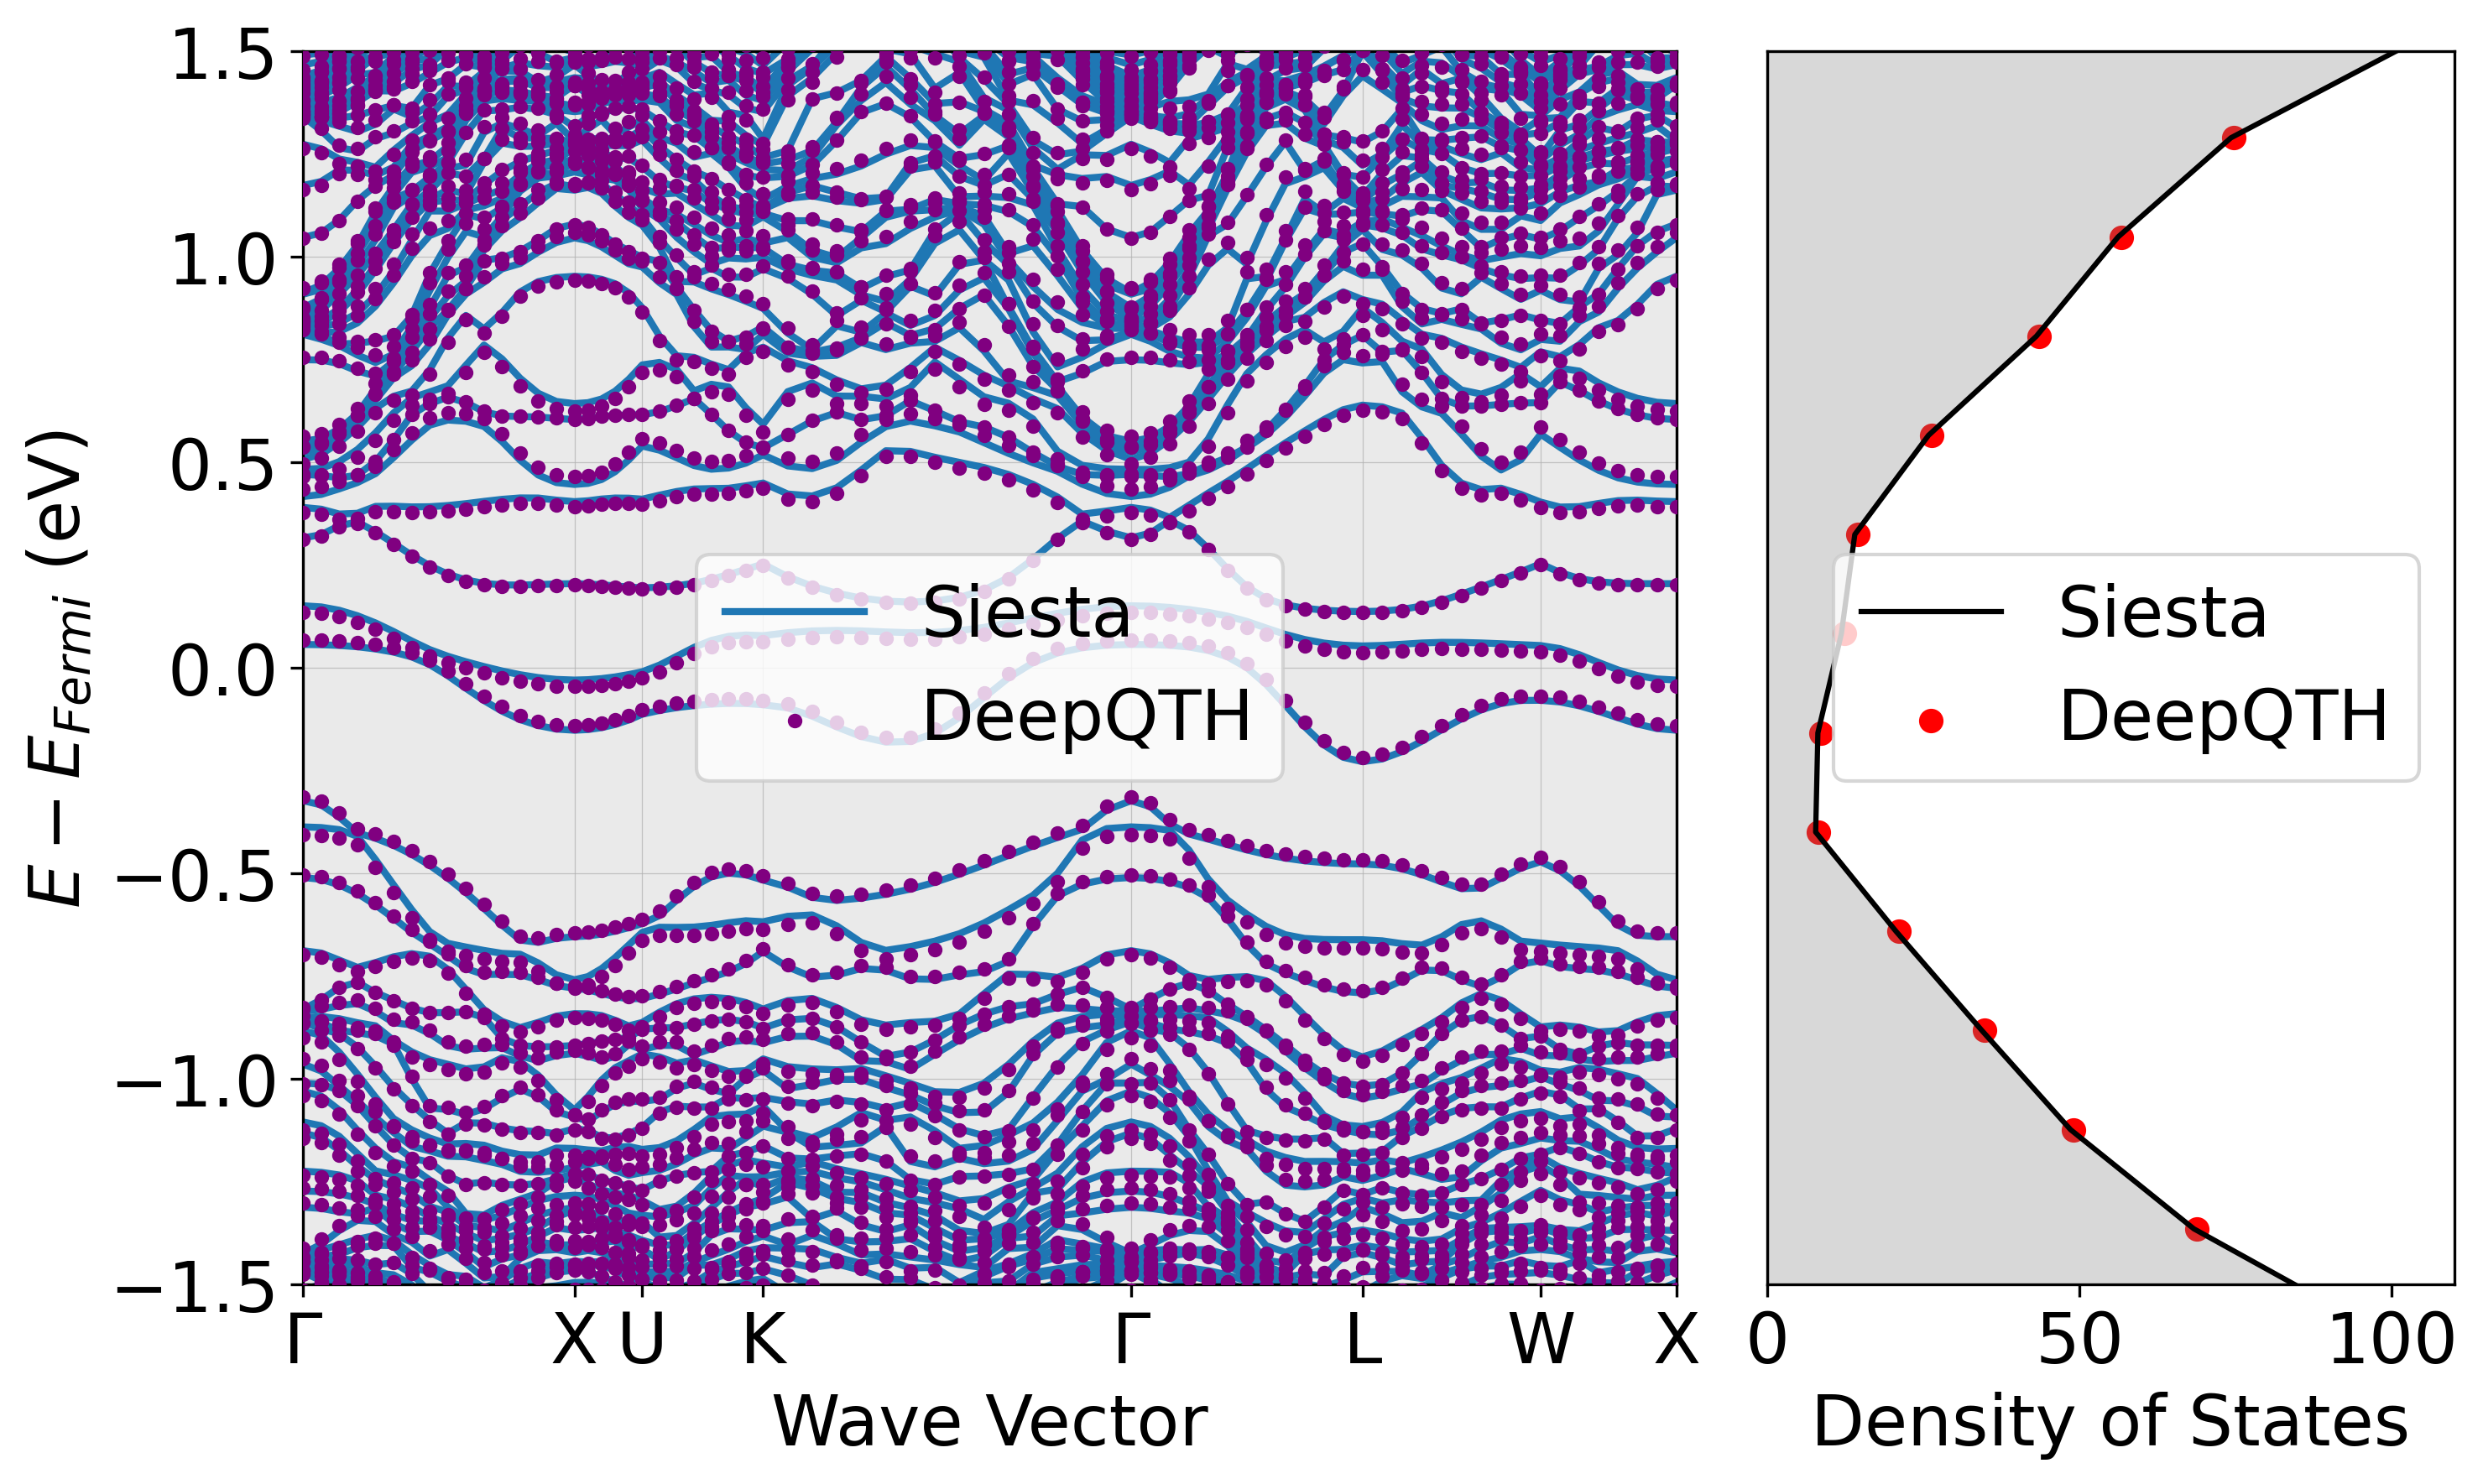

In [23]:
import matplotlib.pyplot as plt
import numpy as np

import random

random.seed(42)
np.random.seed(42)

# 示例数据
wave_vectors = bands_data[0][:,0] / Bohr2Ang # 波矢
energy_bands = [bands_data[i][:,1] - E_F for i in range(len(bands_data))]  # 模拟多个能带
density_of_states_total = DOS1  # 总态密度
energy_dos = E_points- E_F  # 态密度的能量轴

# 创建图形
fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=300, gridspec_kw={'width_ratios': [2, 1]})

# 绘制能带图
i = 0
for band in energy_bands:
    if i == 0:
        axs[0].plot(wave_vectors, band, color='#1f77b4', linewidth=2.0, label='Siesta')
        axs[0].scatter(wave_vectors, band+random.uniform(-0.02, 0.02), color='purple', s=10, zorder=5, label='DeepQTH')  # 示例点
    else:
        axs[0].plot(wave_vectors, band, color='#1f77b4', linewidth=2.0)
        axs[0].scatter(wave_vectors, band+random.uniform(-0.02, 0.02), color='purple', s=10, zorder=5)  # 示例点
    i = i + 1
axs[0].set_facecolor("#eaeaea")
axs[0].set_xlabel("Wave Vector", fontsize=20)
axs[0].set_ylabel(r"$E - E_{Fermi}$ (eV)", fontsize=20)
axs[0].set_xticks([k_points[new_xtick] for new_xtick in new_xticks])
axs[0].set_xticklabels(xticks_list)
axs[0].grid(True, linewidth=0.3, alpha=0.7)
axs[0].set_ylim(-1.5, 1.5)
axs[0].set_xlim(wave_vectors[0], wave_vectors[-1])
axs[0].legend(loc='center', bbox_to_anchor=(0.5, 0.5), fontsize=20)
# axs[0].grid(color='white', linestyle='-', linewidth=0.5, alpha=0.7)

# 绘制态密度图
axs[1].plot(density_of_states_total, energy_dos, color='black', label="Siesta")
axs[1].scatter(density_of_states_total+random.uniform(-0.5, 0.5), energy_dos, color='red', label="DeepQTH")
axs[1].fill_betweenx(energy_dos, 0, density_of_states_total, color='gray', alpha=0.3)
axs[1].set_xlabel("Density of States", fontsize=20)
axs[1].legend(loc='center right', fontsize=20)
axs[1].set_yticks([])  # 移除右侧子图的y轴刻度
axs[1].set_ylim(-1.5, 1.5)
axs[1].set_xlim(0, 110)

# 放大刻度字体
axs[0].tick_params(axis='both', labelsize=20)
axs[1].tick_params(axis='both', labelsize=20)

# 调整布局
plt.tight_layout()

# 保存为高清矢量图
plt.savefig("/fs2/home/ndsim10/DeepH-final/si_example/work_dir/olp/si_215_defect_and_doping/band_dos_plot.svg", format='svg', bbox_inches='tight')

plt.show()

P_E_F = -3.6664
P_k_min = 0.0
P_k_max = 0.14206
Predicted Total number of bands = 5850
First group of predicted data:
5850


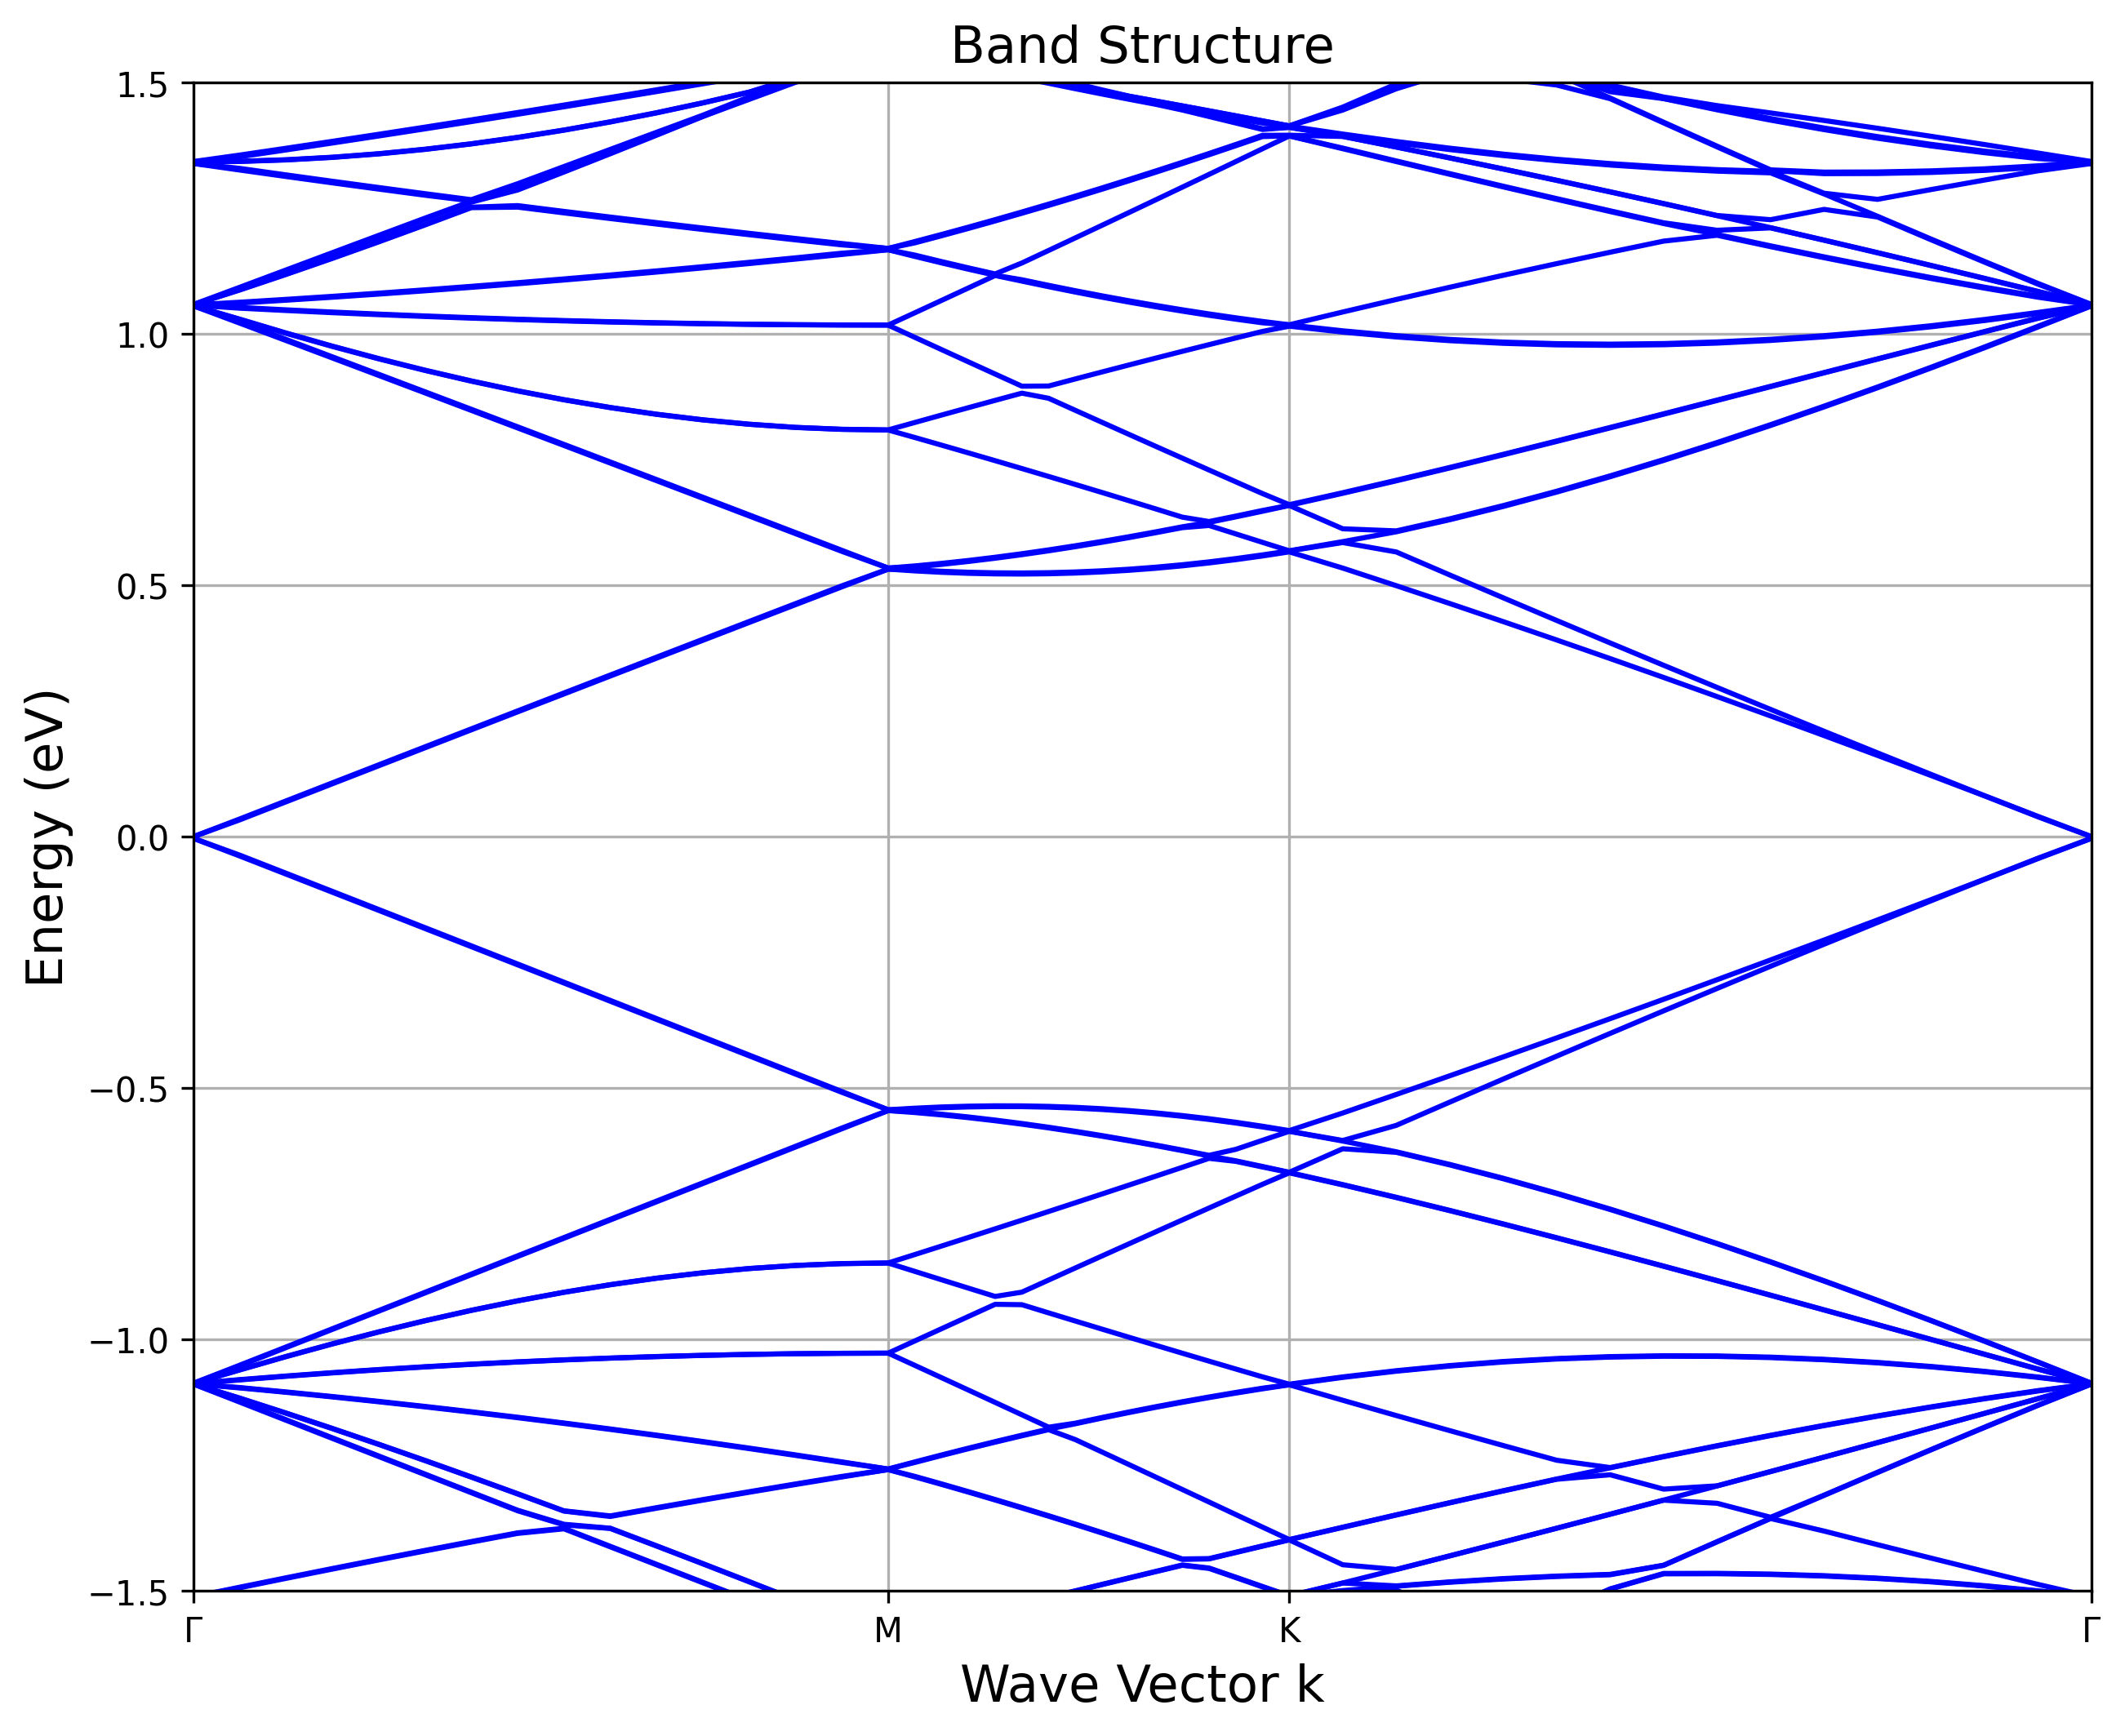

In [21]:
# 初始化变量
P_E_F = None
P_k_min = None
P_k_max = None
P_total_bands = None
P_bands_data = []
P_current_band = []
# 打开deeph预测的siesta.dat文件并逐行读取
with open('/fs2/home/ndsim10/DeepH-final/graphene_example/work_dir/inference/graphene450/pred_bands.dat', 'r') as file:
    for line in file:
        # 去除行尾的换行符
        line = line.strip()
        # 检查是否是参数行
        if line.startswith('# E_F'):
            P_E_F = float(line.split('=')[1])
        elif line.startswith('# k_min, k_max'):
            k_values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            P_k_min, P_k_max = map(float, k_values)
        elif line.startswith('# E_min, E_max'):
            E_values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            E_min, E_max = map(float, E_values)
        elif line.startswith('# Nbands, Nspin, Nk'):
            P_total_bands = int(line.split('=')[1].split('\t')[1])
        # 检查是否是数据行
        elif re.match(r"^\d", line):
            P_current_band.append(list(map(float, line.split())))
        # 如果遇到空行且当前组数据不为空，则开始新的数据组
        elif line == '' and P_current_band:
            P_bands_data.append(np.array(P_current_band))
            P_current_band = []

# 如果最后一组数据非空，也添加到bands_data中
if P_current_band:
    P_bands_data.append(np.array(P_current_band))

# 打印提取的参数
print(f"P_E_F = {P_E_F}")
print(f"P_k_min = {P_k_min}")
print(f"P_k_max = {P_k_max}")
print(f"Predicted Total number of bands = {P_total_bands}")
# 打印第一组数据用于验证
print("First group of predicted data:")
# for data in P_bands_data[0]:
#     print(data)

print(len(P_bands_data))
# assert len(bands_data) == len(P_bands_data)


xlim_min_gamma = None
xlim_max_gamma = None
M = None
K = None
plt.figure(figsize=(10,8), dpi=300)
for i in range(len(P_bands_data)):
    pred_k_points = P_bands_data[i][:,0]  # k点数据
    pred_bands = P_bands_data[i][:,1] - P_E_F#费米能级归零  石墨烯：3.6522
    xlim_min_gamma = pred_k_points[0]
    xlim_max_gamma = pred_k_points[-1]
    M = pred_k_points[15]
    K = pred_k_points[30]
    # print(xlim_min_gamma, M, K, xlim_max_gamma)
    # pred_k_points = P_bands_data[i][:, 0]
    # pred_bands = P_bands_data[i][:, 1] + 3.65189#费米能级归零
    plt.plot(pred_k_points, pred_bands, color='b')  # 绘制每条能带
    # plt.scatter(pred_k_points, pred_bands, marker='o',color='r', s=5)  # 绘制每条能带

plt.xlabel('Wave Vector k', fontsize=15)
plt.ylabel('Energy (eV)', fontsize=15)
plt.ylim(-1.5,1.5) #eV
plt.xlim(xlim_min_gamma, xlim_max_gamma)
plt.xticks([xlim_min_gamma, M, K, xlim_max_gamma], ['Γ', 'M', 'K', 'Γ']) #[0,0,0], [0,0.5,0], [1/3,2/3,0], [0,0,0]
plt.title('Band Structure', fontsize=15)
plt.grid(True)
# plt.savefig('/fs2/home/ndsim10/deeph/example/work_dir/inference/5_4/band_structure.png')
plt.show()

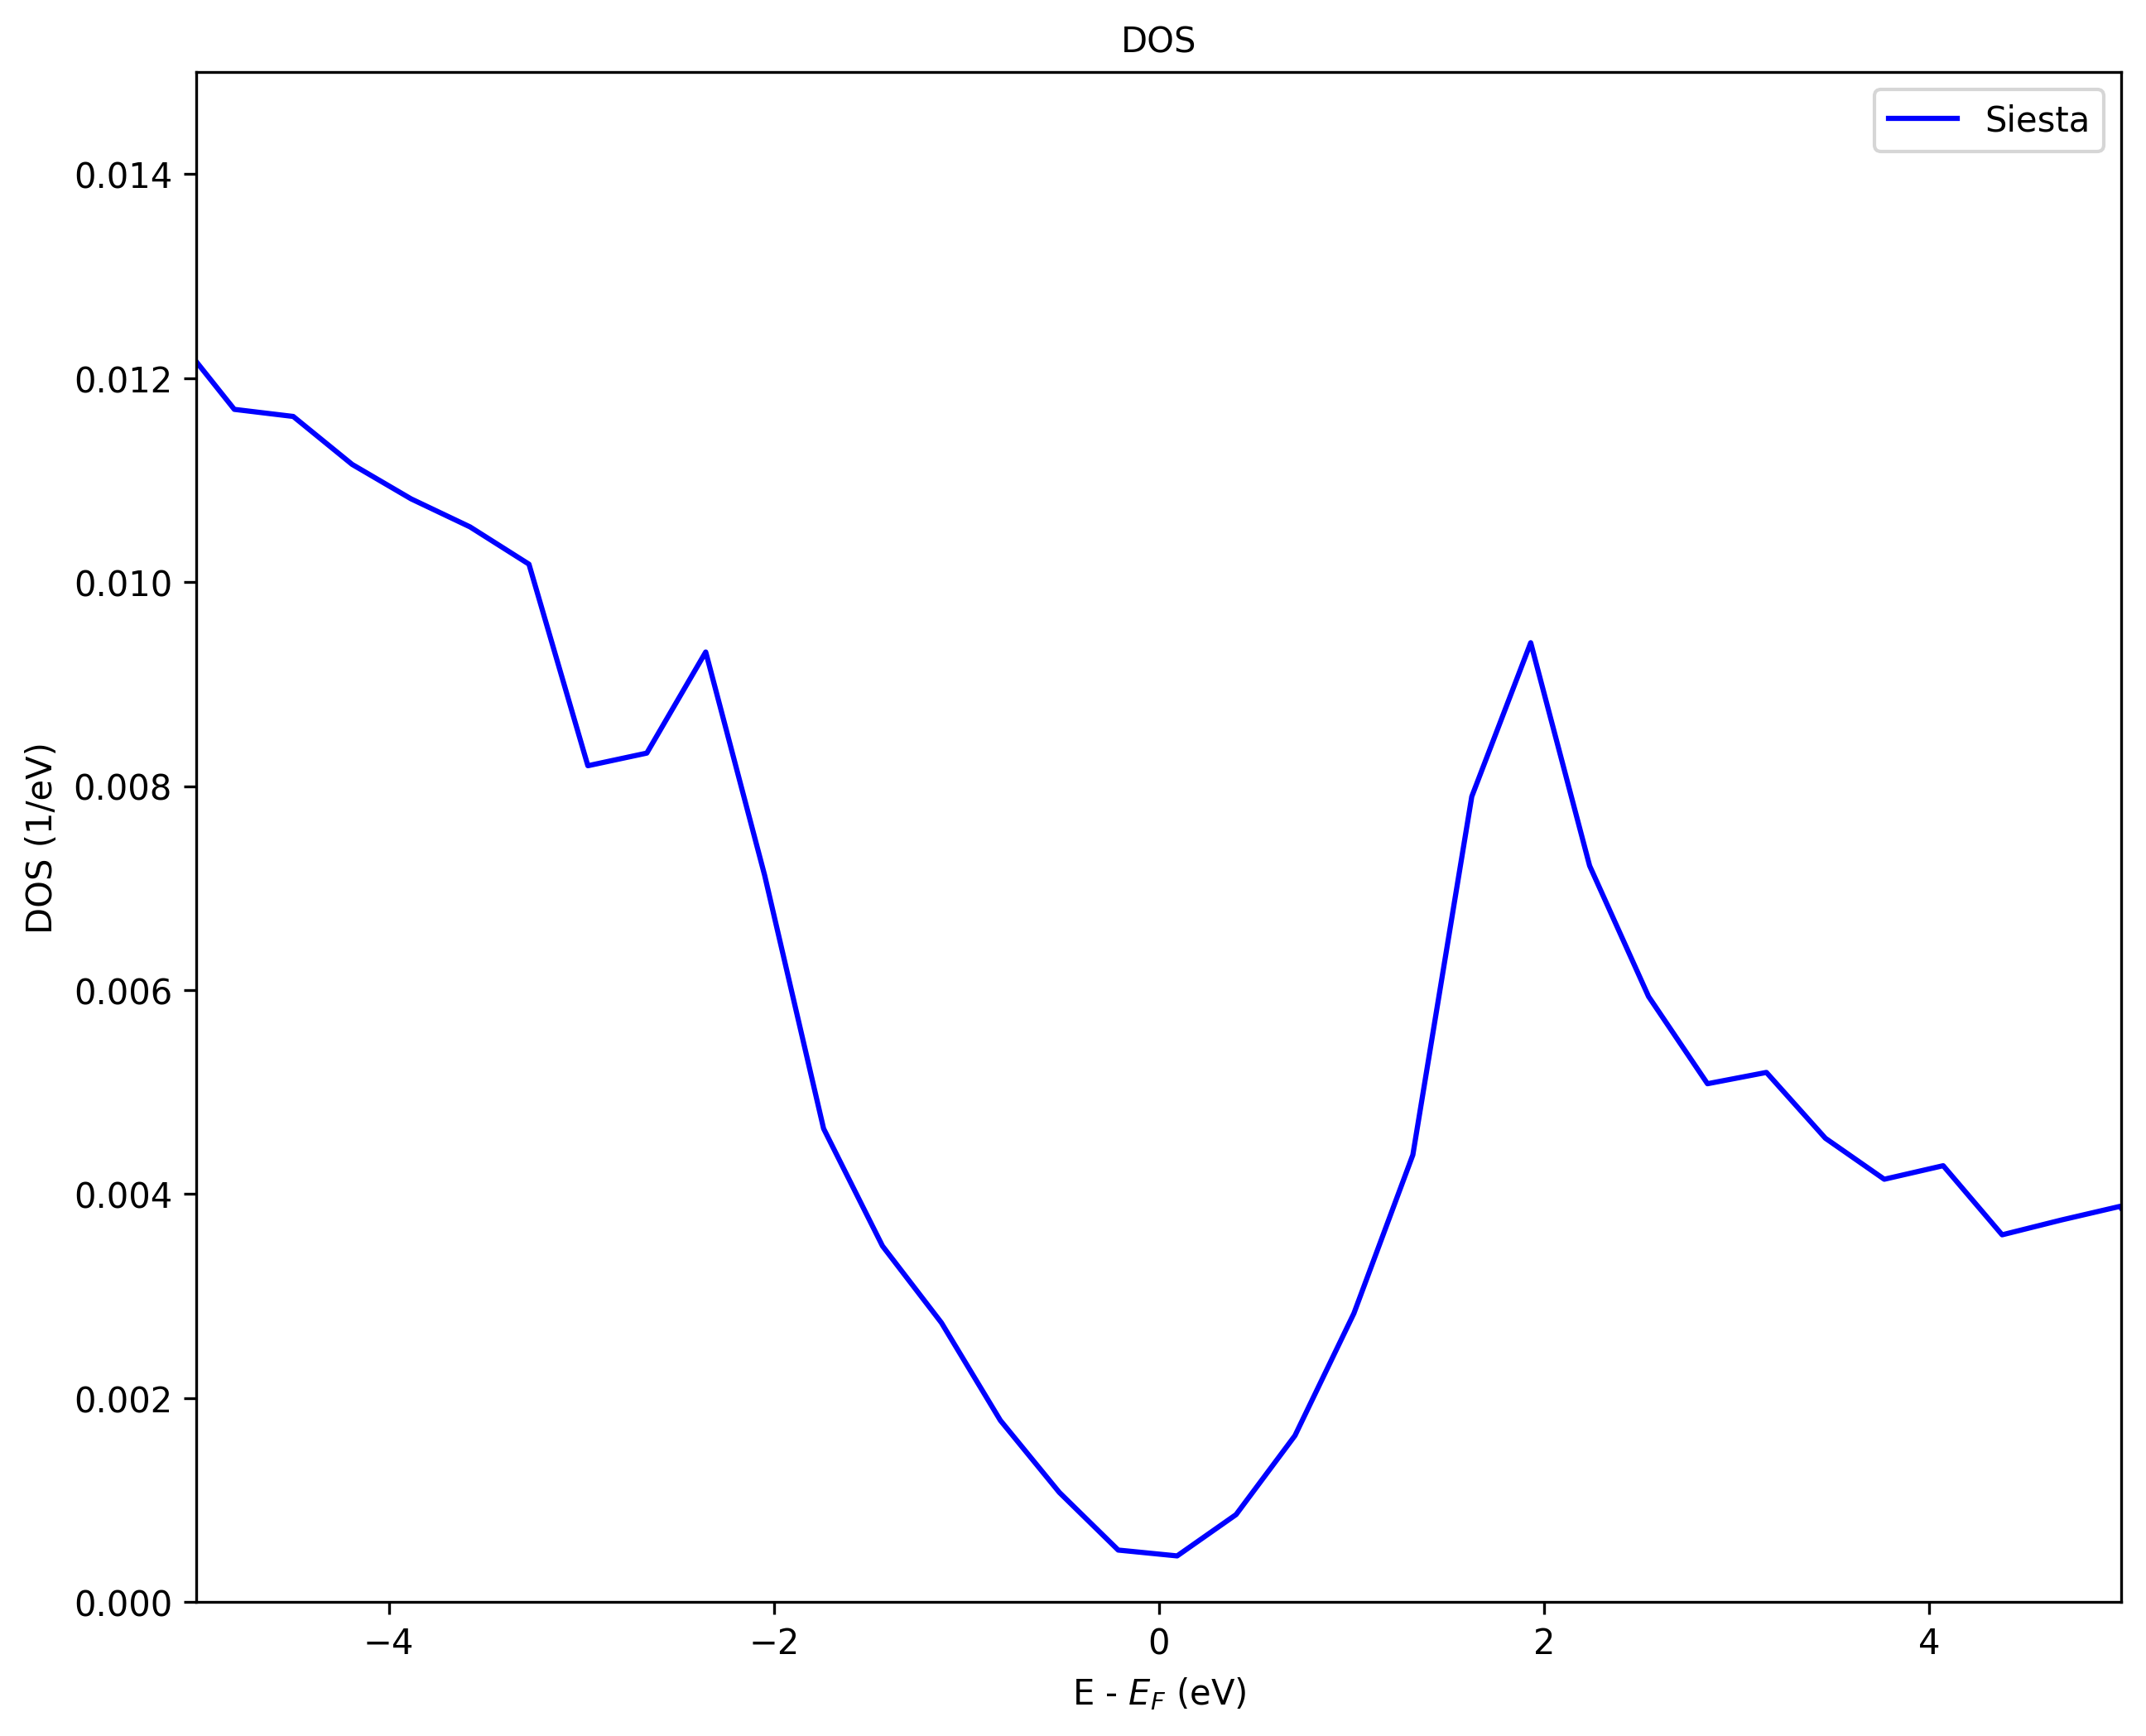

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import random

# input_path = '/fs2/home/ndsim10/all-kinds-test/graphene-defect/DV5555-6-7777/'
dos_data1 = np.loadtxt('/fs2/home/ndsim10/DeepH-final/graphene_example/work_dir/inference/graphene450/pred_dos.dat')
# dos_data2 = np.loadtxt('/fs2/home/ndsim10/deeph/example/work_dir/olp/5_4/dos.dat')
E_points = dos_data1[:,0]
#费米能级：SVED:-3.835； SV59:-3.8947;  SV55-66:-3.835;  SW:-3.6111
DOS1 = dos_data1[:,1] #1up,2down,3total   #450个原子fermi_level = -3.6522  + 3.7697
# DOS2 = DOS1 + np.random.uniform(-1, 1)
plt.figure(figsize=(10,8), dpi=300)
plt.plot(E_points  - P_E_F, DOS1, color='blue', label="Siesta",linewidth=1.5)  # 绘制每条能带
# plt.scatter(E_points  - P_E_F, DOS1+random.uniform(-0.4, 0.4), marker='o',color='red', s=3, label="DeepQTH")
plt.xlim(-5, 5)
plt.ylim(0, 0.015)
plt.xlabel(r'E - $E_F$ (eV)', fontsize=10)#r'MAE of $H^\prime_{iu, jv}$'
plt.ylabel('DOS (1/eV)', fontsize=10)
plt.title('DOS', fontsize=10)
# plt.grid(True)
plt.legend()
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png')
plt.show()

In [23]:
P_bands_data[259][:,0]

array([0.      , 0.003466, 0.006933, 0.010399, 0.013866, 0.017332,
       0.020799, 0.024265, 0.027732, 0.031198, 0.034665, 0.038131,
       0.041598, 0.045064, 0.048531, 0.051997, 0.053999, 0.056   ,
       0.058002, 0.060003, 0.062004, 0.064006, 0.066007, 0.068009,
       0.07001 , 0.072011, 0.074013, 0.076014, 0.078015, 0.080017,
       0.082018, 0.086021, 0.090024, 0.094027, 0.098029, 0.102032,
       0.106035, 0.110038, 0.11404 , 0.118043, 0.122046, 0.126049,
       0.130051, 0.134054, 0.138057, 0.14206 ])

In [24]:
len(P_bands_data)

5850

In [27]:
DOS1

array([0.01924227, 0.01589507, 0.01404511, 0.01348108, 0.01241877,
       0.01169465, 0.0116251 , 0.01115484, 0.01081712, 0.0105423 ,
       0.01017675, 0.00820044, 0.00832432, 0.00931563, 0.00712572,
       0.00464305, 0.00349115, 0.00273895, 0.00178178, 0.00107594,
       0.00051028, 0.000453  , 0.00085821, 0.0016331 , 0.0028316 ,
       0.00438497, 0.00789824, 0.00940662, 0.00721949, 0.00593793,
       0.00508264, 0.00519353, 0.0045485 , 0.00414614, 0.00427902,
       0.00360121, 0.00374574, 0.0038802 , 0.00303776, 0.00315991,
       0.0033106 , 0.00292655, 0.00286918, 0.00288813, 0.00278519,
       0.00593262, 0.01208787, 0.01593721, 0.02188433, 0.01934394])

### siesta计算后得到.HSX哈密顿量文件，用sisl包生成的能带结构

In [256]:
geom = sisl.get_sile("/fs2/home/ndsim10/all-kinds-test/si_250/input.fdf").read_geometry()
hsx = hsxSileSiesta("/fs2/home/ndsim10/all-kinds-test/si_250/siesta.HSX")
H = hsx.read_hamiltonian(geometry=geom)
S = hsx.read_overlap(geometry=geom) #这个方式是单独读取出重叠矩阵，与H.S的值相同。
print(H)

Hamiltonian{non-zero: 4977250, orthogonal: False,
 Spin{unpolarized, kind=f},
 Geometry{na: 250, no: 3250,
  Atoms{species: 1,
   Atom{Si, Z: 14, mass(au): 28.09000, maxR: 3.28160,
    AtomicOrbital{3sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 2.6072000000000153, q0: 2.0}},
    AtomicOrbital{3sZ2, q0: 0.0, SphericalOrbital{l: 0, R: 2.228400000000018, q0: 0.0}},
    AtomicOrbital{3pyZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 3.2682000000000175, q0: 2.0}},
    AtomicOrbital{3pzZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 3.2682000000000175, q0: 2.0}},
    AtomicOrbital{3pxZ1, q0: 0.6666666666666666, SphericalOrbital{l: 1, R: 3.2682000000000175, q0: 2.0}},
    AtomicOrbital{3pyZ2, q0: 0.0, SphericalOrbital{l: 1, R: 2.539900000000021, q0: 0.0}},
    AtomicOrbital{3pzZ2, q0: 0.0, SphericalOrbital{l: 1, R: 2.539900000000021, q0: 0.0}},
    AtomicOrbital{3pxZ2, q0: 0.0, SphericalOrbital{l: 1, R: 2.539900000000021, q0: 0.0}},
    AtomicOrbital{3dxyZ1P, q0: 0.0, SphericalOrbital

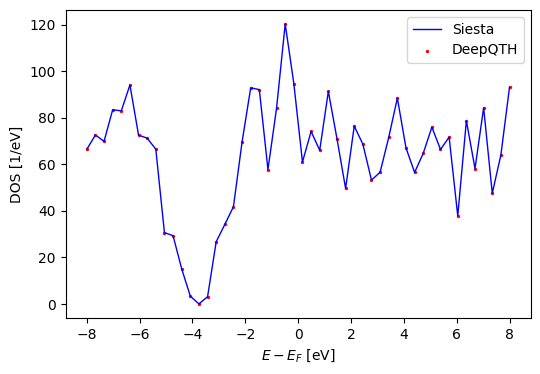

In [257]:
from sisl.physics.electron import *

plt.figure(figsize=(6, 4))
bz = MonkhorstPack(H, [3,3,3])
E = np.linspace(-8,8,50)
eig = bz.apply.average.eigh()

dos = DOS(E, eig.real)
plt.plot(E, dos, color='blue', linewidth=1, label='Siesta')
plt.scatter(E, dos, marker='o',color='red', s=2, label='DeepQTH')
plt.xlabel(r"$E - E_F$ [eV]", fontsize=10)
plt.ylabel(r"DOS [1/eV]", fontsize=10)
# plt.grid()
plt.legend(loc='upper right', fontsize=10)
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png', dpi=300)
plt.show()

(50,)


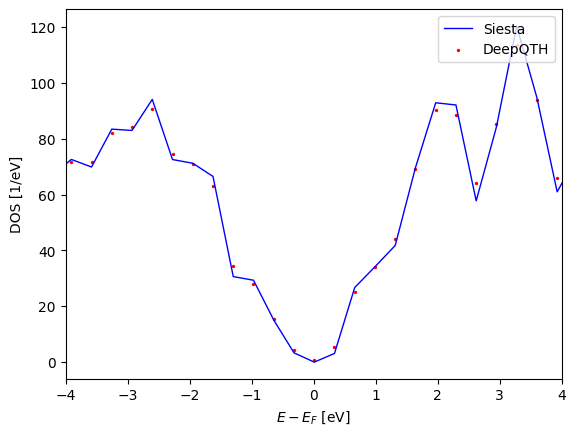

In [258]:
from scipy.ndimage import gaussian_filter1d
# 高斯滤波
smoothed_data = gaussian_filter1d(dos, sigma=0.5)
print(smoothed_data.shape)

plt.plot(E - P_E_F, dos, color='blue', linewidth=1, label='Siesta')
plt.scatter(E - P_E_F, smoothed_data, marker='o', color='red', s=2, label='DeepQTH') #+np.random.uniform(-1, 1, (50,)   
plt.xlabel(r"$E - E_F$ [eV]", fontsize=10)
plt.ylabel(r"DOS [1/eV]", fontsize=10)
plt.xlim(-4,4) #eV
# plt.ylim(0,110) #eV
plt.legend(loc='upper right', fontsize=10)
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png', dpi=300)
plt.show()

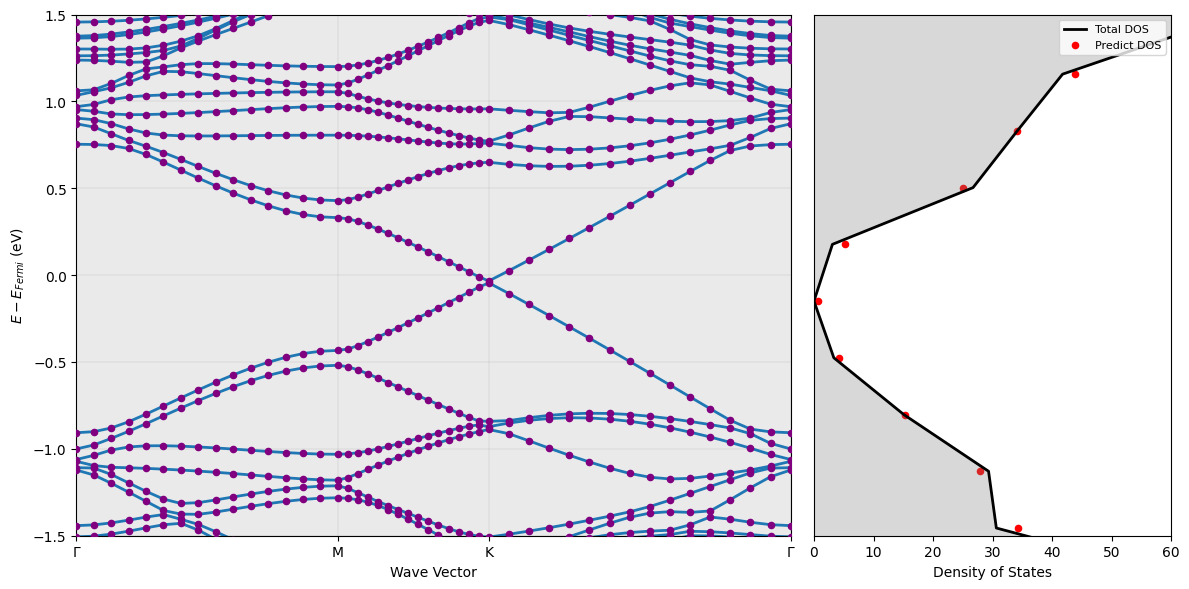

In [270]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
wave_vectors = P_bands_data[0][:,0] / Bohr2Ang # 波矢
energy_bands = [P_bands_data[i][:,1] - P_E_F for i in range(2600)]  # 模拟多个能带
density_of_states_total = dos  # 总态密度
energy_dos = E- P_E_F  # 态密度的能量轴

# 创建图形
fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

# 绘制能带图
for band in energy_bands:
    axs[0].plot(wave_vectors, band, color='#1f77b4', linewidth=2.0, label='Siesta')
    axs[0].scatter(wave_vectors, band, color='purple', s=20, zorder=5, label='DeepQTH')  # 示例点
axs[0].set_facecolor("#eaeaea")
axs[0].set_xlabel("Wave Vector")
axs[0].set_ylabel(r"$E - E_{Fermi}$ (eV)")
axs[0].set_xticks([predict_k_points[new_xtick] for new_xtick in new_xticks])
axs[0].set_xticklabels(xticks_list)
axs[0].grid(True, linewidth=0.3, alpha=0.7)
axs[0].set_ylim(-1.5, 1.5)
axs[0].set_xlim(wave_vectors[0], wave_vectors[-1])
# axs[0].legend(loc='center', fontsize=8)
# axs[0].grid(color='white', linestyle='-', linewidth=0.5, alpha=0.7)

# 绘制态密度图
axs[1].plot(density_of_states_total, energy_dos, color='black', linewidth=2.0, label="Total DOS")
axs[1].scatter(smoothed_data, energy_dos, color='red', s=20, label="Predict DOS")
axs[1].fill_betweenx(energy_dos, 0, density_of_states_total, color='gray', alpha=0.3)
axs[1].set_xlabel("Density of States")
axs[1].legend(loc='upper right', fontsize=8)
axs[1].set_yticks([])  # 移除右侧子图的y轴刻度
axs[1].set_ylim(-1.5, 1.5)
axs[1].set_xlim(0, 60)

# 调整布局
# plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.2, wspace=0.3)  # 手动调整边距
plt.tight_layout()
plt.show()

(1, 3250, 50)
(3250, 50)
(13, 50)


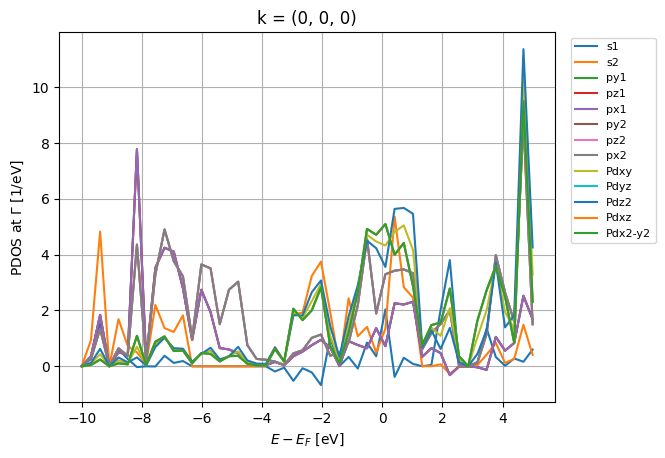

In [158]:
es = H.eigenstate(k=(0, 0, 0))
E = np.linspace(-10, 5, 50)
# E = np.linspace(-1, -0.5, 50)
dE = E[1] - E[0]
PDOS = es.PDOS(E)  #PDOS：(1, 5850, 50)，np.array类型
# PDOS = es.PDOS(E)
print(PDOS.shape)
PDOS_data = PDOS.sum((0)) * dE  #PDOS：(1, 5850, 50)，np.array类型
print(PDOS_data.shape)
pdos = np.zeros((13,50))
for i in range(13):
    for j in range(250): #800个原子
        pdos[i,:] = pdos[i,:] + PDOS_data[i+13*j,:]
# print(pdos)
print(pdos.shape)
plt.grid()
plt.plot(E, pdos[0,:], label='s1')
plt.plot(E, pdos[1,:], label='s2')
plt.plot(E, pdos[2,:], label='py1')
plt.plot(E, pdos[3,:], label='pz1')
plt.plot(E, pdos[4,:], label='px1')
plt.plot(E, pdos[5,:], label='py2')
plt.plot(E, pdos[6,:], label='pz2')
plt.plot(E, pdos[7,:], label='px2')
plt.plot(E, pdos[8,:], label='Pdxy')
plt.plot(E, pdos[9,:], label='Pdyz')
plt.plot(E, pdos[10,:], label='Pdz2')
plt.plot(E, pdos[11,:], label='Pdxz')
plt.plot(E, pdos[11,:], label='Pdx2-y2')
plt.legend(bbox_to_anchor=(1.02, 1), fontsize = 8)
plt.title(r"k = (0, 0, 0)")
plt.xlabel(r"$E - E_F$ [eV]")
plt.ylabel(r"PDOS at $\Gamma$ [1/eV]")
plt.show()

In [41]:
bs = BandStructure(
    H,
    [[0,0,0], [0.5,0,0], [0.33333333,0.33333333,0], [0,0,0]],
    46,
    [r"Γ", r"M", r"K", r"Γ"]
)
lk, kt, kl = bs.lineark(True)
print(lk, kt, kl)
bs_eig = bs.apply.array.eigh()
# print(bs_eig)
print(bs_eig.shape)

[0.         0.00578006 0.01156012 0.01734017 0.02312023 0.02890029
 0.03468035 0.0404604  0.04624046 0.05202052 0.05780058 0.06358063
 0.06936069 0.07514075 0.08092081 0.08670086 0.09248092 0.09826098
 0.10456442 0.11086787 0.11717131 0.12347476 0.1297782  0.13608165
 0.14238509 0.14868854 0.15499198 0.16096366 0.16693535 0.17290703
 0.17887872 0.1848504  0.19082209 0.19679377 0.20276546 0.20873714
 0.21470882 0.22068051 0.22665219 0.23262388 0.23859556 0.24456725
 0.25053893 0.25651061 0.2624823  0.26845398] [0.         0.09826098 0.15499198 0.26845398] ['Γ', 'M', 'K', 'Γ']
(46, 5850)


In [42]:
predict_k_points

array([0.        , 0.00654979, 0.01310147, 0.01965126, 0.02620294,
       0.03275273, 0.03930441, 0.0458542 , 0.05240588, 0.05895567,
       0.06550735, 0.07205714, 0.07860882, 0.08515861, 0.09171029,
       0.09826008, 0.10204331, 0.10582466, 0.10960789, 0.11338923,
       0.11717057, 0.1209538 , 0.12473514, 0.12851837, 0.13229972,
       0.13608106, 0.13986429, 0.14364563, 0.14742697, 0.1512102 ,
       0.15499155, 0.16255612, 0.17012069, 0.17768338, 0.18524795,
       0.19281252, 0.2003771 , 0.20794167, 0.21550435, 0.22306892,
       0.2306335 , 0.23819807, 0.24576075, 0.25332533, 0.2608899 ,
       0.26845447])

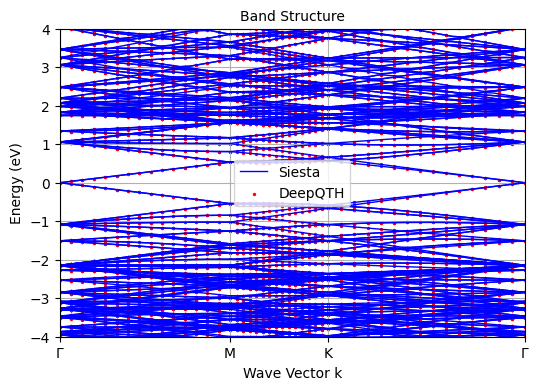

In [102]:
plt.figure(figsize=(6, 4))
plt.xlabel('Wave Vector k', fontsize=10)
plt.ylabel('Energy (eV)', fontsize=10)
plt.title('Band Structure', fontsize=10)

for i in range(bs_eig.shape[1]):
    if i == 0:
        plt.plot(lk, bs_eig[:, i] + 3.6518, color='blue', linewidth=1, label='Siesta') # 绘制每条能带
    else:
        plt.plot(lk, bs_eig[:, i] + 3.6518, color='blue', linewidth=1) # 绘制每条能带

for i in range(len(P_bands_data)):
    predict_k_points = P_bands_data[i][:,0] / Bohr2Ang  # k点数据
    predict_bands = P_bands_data[i][:,1] - P_E_F#费米能级归零  石墨烯：3.6522
    # print(predict_k_points)
    # plt.plot(predict_k_points, predict_bands, color='blue', linewidth=1, label='DFT')  # 绘制每条能带
    if i == 0:
        plt.scatter(predict_k_points, predict_bands, marker='o',color='red', s=2, label='DeepQTH')  # 绘制每条能带
    else:
        plt.scatter(predict_k_points, predict_bands, marker='o',color='red', s=2)  # 绘制每条能带
    
plt.legend(loc='center', fontsize=10)
# plt.savefig('/fs2/home/ndsim10/deeph/example/work_dir/inference/5_4/band_structure.png')
plt.ylim(-4, 4)
plt.xlim(kt[0], kt[-1])
plt.xticks(kt, kl)
plt.grid()
plt.show()

In [39]:
bs = BandStructure(
    H,
    [[0,0,0], [0.5,0,0], [0.333333,0,0.333333], [0,0,0]],
    45,
    [r"Γ", r"M", r"K", r"Γ"]
)
lk, kt, kl = bs.lineark(True)
print(lk, kt, kl)
bs_eig = bs.apply.array.eigh()
# print(bs_eig)
print(bs_eig.shape)

[0.         0.00893282 0.01786563 0.02679845 0.03573126 0.04466408
 0.0535969  0.06252971 0.07146253 0.08039535 0.08932816 0.09826098
 0.10722451 0.11618804 0.12515157 0.13411509 0.14307862 0.15204215
 0.16100568 0.16996921 0.17893274 0.18789627 0.1968598  0.20582333
 0.21478686 0.22375039 0.23271391 0.24167744 0.25074975 0.25982207
 0.26889438 0.27796669 0.287039   0.29611131 0.30518362 0.31425594
 0.32332825 0.33240056 0.34147287 0.35054518 0.35961749 0.36868981
 0.37776212 0.38683443 0.39590674] [0.         0.09826098 0.24167744 0.39590674] ['Γ', 'M', 'K', 'Γ']


KeyboardInterrupt: 

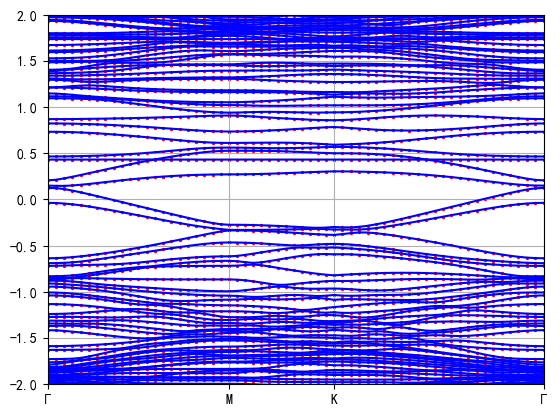

In [154]:
for i in range(bs_eig.shape[1]):
    plt.plot(lk, bs_eig[:, i] + 3.824, color='blue')
    plt.scatter(lk, bs_eig[:, i] + 3.824, color='red', s=2)
plt.ylim(-2, 2)
plt.xlim(kt[0], kt[-1])
plt.xticks(kt, kl)
plt.grid()
plt.show()

In [87]:
real_bands_data = bs_eig.T

### sisl计算的和预测的能带结构对比

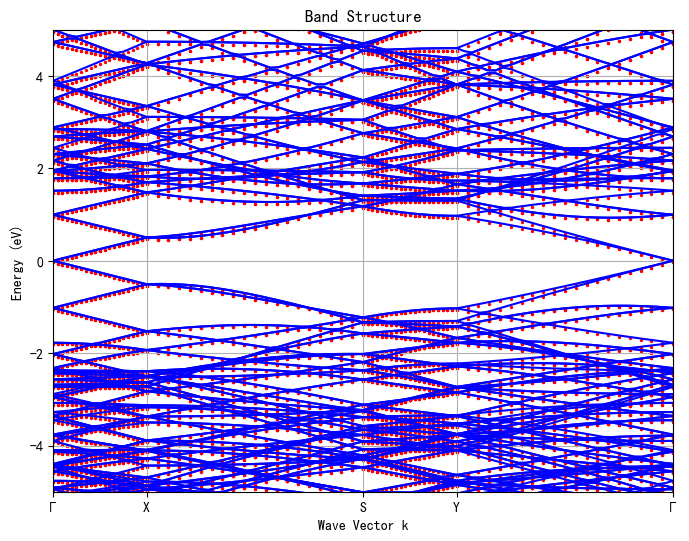

In [88]:
assert real_bands_data.shape[0] == len(P_bands_data)
assert real_bands_data.shape[1] == P_bands_data[0].shape[0]

plt.figure(figsize=(8, 6))
for i in range(len(P_bands_data)):
    predict_k_points = P_bands_data[i][:,0] / Bohr2Ang  # k点数据
    predict_bands = P_bands_data[i][:,1] - P_E_F#费米能级归零  石墨烯：3.6522
    real_k_points = lk  # k点数据
    real_bands = real_bands_data[i] - P_E_F#费米能级归零  石墨烯：3.6522

    plt.plot(real_k_points, real_bands, color='b')  # 绘制每条能带
    # plt.plot(predict_k_points, predict_bands, color='r')  # 绘制每条能带
    plt.scatter(predict_k_points, predict_bands, marker='o',color='r', s=2)  # 绘制每条能带

plt.xlabel('Wave Vector k')
plt.ylabel('Energy (eV)')
plt.ylim(-5,5) #eV
plt.xlim(predict_k_points[0], predict_k_points[-1])
plt.xticks([predict_k_points[new_xtick] for new_xtick in new_xticks], xticks_list)
plt.title('Band Structure')
plt.grid(True)
# plt.savefig('/fs2/home/ndsim10/deeph/example/work_dir/inference/5_4/band_structure.png')
plt.show()

### 预测计算时的k点和sisl包自动采集的k点不同

In [83]:
predict_k_points

array([0.    , 0.0046, 0.0092, 0.0138, 0.0184, 0.023 , 0.0277, 0.0323,
       0.0369, 0.0415, 0.0461, 0.0507, 0.0553, 0.0599, 0.0645, 0.0691,
       0.0737, 0.0784, 0.083 , 0.0876, 0.0922, 0.1028, 0.1135, 0.1241,
       0.1348, 0.1454, 0.156 , 0.1667, 0.1773, 0.188 , 0.1986, 0.2093,
       0.2199, 0.2306, 0.2412, 0.2518, 0.2625, 0.2731, 0.2838, 0.2944,
       0.3051, 0.3097, 0.3143, 0.3189, 0.3235, 0.3281, 0.3327, 0.3373,
       0.3419, 0.3466, 0.3512, 0.3558, 0.3604, 0.365 , 0.3696, 0.3742,
       0.3788, 0.3834, 0.388 , 0.3926, 0.3973, 0.4079, 0.4185, 0.4292,
       0.4398, 0.4505, 0.4611, 0.4718, 0.4824, 0.4931, 0.5037, 0.5143,
       0.525 , 0.5356, 0.5463, 0.5569, 0.5676, 0.5782, 0.5889, 0.5995,
       0.6101])

In [84]:
real_k_points

array([0.    , 0.0077, 0.0154, 0.023 , 0.0307, 0.0384, 0.0461, 0.0538,
       0.0615, 0.0691, 0.0768, 0.0845, 0.0922, 0.0998, 0.1074, 0.115 ,
       0.1226, 0.1302, 0.1378, 0.1454, 0.153 , 0.1606, 0.1682, 0.1758,
       0.1834, 0.191 , 0.1986, 0.2062, 0.2138, 0.2214, 0.229 , 0.2366,
       0.2442, 0.2518, 0.2595, 0.2671, 0.2747, 0.2823, 0.2899, 0.2975,
       0.3051, 0.3128, 0.3204, 0.3281, 0.3358, 0.3435, 0.3512, 0.3588,
       0.3665, 0.3742, 0.3819, 0.3896, 0.3973, 0.4049, 0.4125, 0.4201,
       0.4277, 0.4353, 0.4429, 0.4505, 0.4581, 0.4657, 0.4733, 0.4809,
       0.4885, 0.4961, 0.5037, 0.5113, 0.5189, 0.5265, 0.5341, 0.5417,
       0.5493, 0.5569, 0.5645, 0.5721, 0.5797, 0.5873, 0.5949, 0.6025,
       0.6101])

### 用sisl包生成交互式能带结构图

In [ ]:
band = BandStructure(
    H,
    [[0,0,0], [0.5,0,0], [0.5,0.5,0], [0,0.5,0], [0,0,0]],
    81,
    [r"Γ", r"X", r"S", r"Y", r"Γ"]
)
band.plot(Erange=[-10, 5])

### 读取siesta计算后用gnuband生成的能带结构和态密度

In [40]:
input_path = '/fs2/home/ndsim10/all-kinds-test/mos2_device/dft/'
# 初始化变量
E_F = None
k_min = None
k_max = None
total_bands = None
bands_data = []
current_band = []
# 打开siesta计算的bands.dat文件并逐行读取
with open(input_path+'bands.dat', 'r') as file:
    for line in file:
        # 去除行尾的换行符
        line = line.strip()
        # 检查是否是参数行
        if line.startswith('# E_F'):
            E_F = float(line.split('=')[1])
        elif line.startswith('# k_min, k_max'):
            k_values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            k_min, k_max = map(float, k_values)
        elif line.startswith('# Total number of bands'):
            total_bands = int(line.split('=')[1])
        # 检查是否是数据行
        elif re.match(r"^\s*\d", line):
            current_band.append(list(map(float, line.split())))
        # 如果遇到空行且当前组数据不为空，则开始新的数据组
        elif line == '' and current_band:
            bands_data.append(np.array(current_band))
            current_band = []

# 如果最后一组数据非空，也添加到bands_data中
if current_band:
    bands_data.append(np.array(current_band))

# 打印提取的参数
print(f"E_F = {E_F}")
print(f"k_min = {k_min}")
print(f"k_max = {k_max}")
print(f"Total number of bands = {total_bands}")
print(f"the number of kpoints = {len(bands_data[0])}")
# 打印第一组数据用于验证
print("First group of data:")
for data in bands_data[0]:
    print(data)

E_F = -4.0021
k_min = 0.0
k_max = 0.2414
Total number of bands = 4920
the number of kpoints = 46
First group of data:
[  0.     -18.7163   1.    ]
[ 5.8340e-03 -1.8716e+01  1.0000e+00]
[ 1.16690e-02 -1.87151e+01  1.00000e+00]
[ 1.75030e-02 -1.87135e+01  1.00000e+00]
[  0.023338 -18.7114     1.      ]
[  0.029172 -18.7086     1.      ]
[  0.035006 -18.7052     1.      ]
[  0.040841 -18.7012     1.      ]
[  0.046675 -18.6965     1.      ]
[  0.05251 -18.6913    1.     ]
[  0.058344 -18.6854     1.      ]
[  0.064179 -18.679      1.      ]
[  0.070013 -18.6719     1.      ]
[  0.075847 -18.6642     1.      ]
[  0.081682 -18.6559     1.      ]
[  0.087516 -18.647      1.      ]
[  0.089882 -18.65       1.      ]
[  0.092248 -18.653      1.      ]
[  0.094614 -18.6558     1.      ]
[  0.09698 -18.6585    1.     ]
[  0.099346 -18.6611     1.      ]
[  0.101712 -18.6636     1.      ]
[  0.104078 -18.666      1.      ]
[  0.106444 -18.6684     1.      ]
[  0.10881 -18.6706    1.     ]
[  0.11

In [41]:
# 打开input.fdf文件，读取k路径的点数
elements = []
with open(input_path + 'RUN.fdf', 'r') as file:
    within_block = None
    for line in file:
        # 检查是否到达区块开始
        if '%block Band' in line:
            within_block = True
            continue  # 跳过当前行，不做处理
        # 检查是否到达区块结束
        elif '%endblock Band' in line:
            within_block = False
            break  # 区块结束，退出循环
        # 处理区块内的内容
        if within_block:
            element = line.split()  # 拆分行内容为列表
            print(element)
            if element:  # 确保行非空
                elements.append(element)
xticks_list = [str(element[-1]) for element in elements]
xticks_v_list = [int(element[0]) for element in elements]
cumulative_sums = list(accumulate(xticks_v_list))
new_xticks = [item - 1 for item in cumulative_sums]

['1', '0.0', '0.0', '0.0', 'GAMMA']
['15', '0.0', '0.5', '0.0', 'M']
['15', '0.333333333', '0.666666667', '0.0', 'K']
['15', '0.0', '0.0', '0.0', 'GAMMA']


In [42]:
new_xticks

[0, 15, 30, 45]

In [43]:
xticks_list

['GAMMA', 'M', 'K', 'GAMMA']

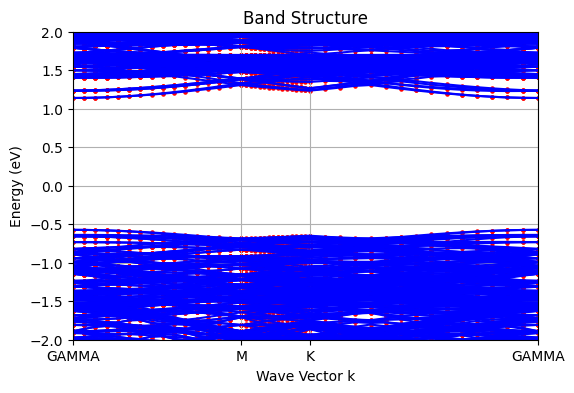

In [44]:
plt.figure(figsize=(6, 4))
for i in range(len(bands_data)):
    real_k_points = bands_data[i][:,0]  # k点数据
    real_bands = bands_data[i][:,1] - E_F#费米能级归零  石墨烯：3.6522
    
    plt.plot(real_k_points, real_bands, color='b')  # 绘制每条能带
    plt.scatter(real_k_points, real_bands, marker='o',color='r', s=5)  # 绘制每条能带

plt.xlabel('Wave Vector k')
plt.ylabel('Energy (eV)')
plt.ylim(-2,2) #eV
plt.xlim(real_k_points[0], real_k_points[-1])
plt.xticks([real_k_points[new_xtick] for new_xtick in new_xticks], xticks_list)
plt.title('Band Structure')
plt.grid(True)
# plt.savefig('/fs2/home/ndsim10/deeph/example/work_dir/inference/5_4/band_structure.png')
plt.show()

### 读取siesta计算后用EIG2DOS生成的态密度

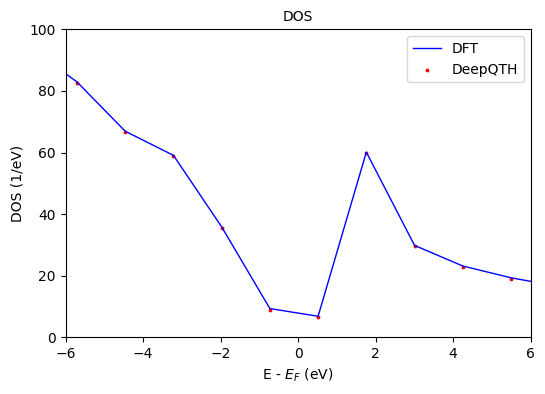

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import random

input_path = '/fs2/home/ndsim10/graphene_example/work_dir/olp/graphene450/'
dos_data1 = np.loadtxt(input_path + 'dos.dat')
# dos_data2 = np.loadtxt('/fs2/home/ndsim10/deeph/example/work_dir/olp/5_4/dos.dat')
E_points = dos_data1[:,0]
#费米能级：SVED:-3.835； SV59:-3.8947;  SV55-66:-3.835;  SW:-3.6111
DOS1 = dos_data1[:,1] #1up,2down,3total   #450个原子fermi_level = -3.6522  + 3.7697
# DOS2 = DOS1 + np.random.uniform(-1, 1)
plt.figure(figsize=(6, 4))
plt.plot(E_points  - P_E_F, DOS1, color='blue', label="DFT",linewidth=1)  # 绘制每条能带
plt.scatter(E_points  - P_E_F, DOS1+random.uniform(-0.4, 0.4), marker='o',color='red', s=3, label="DeepQTH")
plt.xlim(-6, 6)
plt.ylim(0, 100)
plt.xlabel(r'E - $E_F$ (eV)', fontsize=10)#r'MAE of $H^\prime_{iu, jv}$'
plt.ylabel('DOS (1/eV)', fontsize=10)
plt.title('DOS', fontsize=10)
# plt.grid(True)
plt.legend()
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png')
plt.show()